# 2DIsing MC

Constructing a **spins** type.

In [56]:
"""
Represent a state.

fields:  T, J, steps, dimension, spin
"""
mutable struct spins
    T
    J
    steps::Int64
    dimension::Int64
    spin::Array{Int64,2}
    function spins(T, J, steps::Int64 = 100000, dimension::Int64 = 8)
        spin = ones(Int64, dimension, dimension)
        new(T, J, steps, dimension, spin)
    end
end

spins

In [2]:
a = [1 2
3 4]
sum(a)

10

Calculate energy of a state:

In [3]:
"""
Calculate the energy difference after flipping one spin.

Parameter:
conf::spins : Input the state
index::Tuple : An Tuple of index of the flipped spin.
"""
function Energy_Diff(conf::spins, index::Tuple)
    N = conf.dimension   
    S = conf.spin
    m = index[1]  
    n = index[2]
    @assert(m<=N && m>=1 && n<=N && n>=1, "The Index of flipped spin should be within range")
    ΔE = -conf.J * 2 * S[m, n] *
                 (S[mod1(m - 1, N), n] + S[mod1(m + 1, N), n] +
                  S[m, mod1(n - 1, N)] + S[m, mod1(n + 1, N)])
    return ΔE
end

Energy_Diff

Select spin indexs to flip

In [4]:
"""
Choose a spin to flip

Parameter:
conf::spins : the system

Return:
A tuple of index of the spin to flip
"""
function flip_index(conf::spins)
   (rand(1:conf.dimension), rand(1:conf.dimension))
end    

flip_index

flipping a spin

In [5]:
"""
Function to flip a spin

Parameter:
conf::spins : current configuration
index::Tuple : indexs of the flipped spin

Return:
new_config::spins : the new configuration
"""
function flip(conf::spins, index::Tuple)
    conf.spin[index[1], index[2]] = -1 * conf.spin[index[1], index[2]]
    return conf
end

flip

Calculating the energy of the current state:

In [6]:
"""
Calculating the energy of the current state

Parameter:
conf::spins : the current state

Return:
Energy::Float64 : energy of the current state
"""
function Energy(conf::spins)
    S = conf.spin
    N = conf.dimension
    E0 = 0
    for i = 1:N
        for j = 1:N
            E0 = E0 + 0.5 * conf.J * S[i, j] *
                     (S[mod1(i - 1, N), j] + S[mod1(i + 1, N), j] +
                      S[i, mod1(j - 1, N)] + S[i, mod1(j + 1, N)])
        end
    end
    return E0
end

Energy

In [7]:
tryout = spins(2.0,1.0)
flip(tryout,(1,1))
tryout.spin

8×8 Array{Int64,2}:
 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1

Define evolution condition evol_cond()

In [72]:
"""
Deciding whether to flip a chosen spin

Parameter:
conf::spins : The current state.
index::Tuple : A tuple of spin index to flip.

Return:
true of false. true means to flip false means not to
"""
function evol_cond(conf::spins, index::Tuple)
    #index = flip_index(conf.dimension)
    ΔE = Energy_Diff(conf, index)
    
    p = exp(-ΔE / conf.T) / (1 + exp(-ΔE / conf.T))
    r = rand()
    if r < p
        return true
    else
        return false
    end
end

evol_cond

In [79]:
Energy(spins(2, -1))

-128.0

In [10]:
function Base.iterate(conf::spins)
    index = flip_index(conf.dimension)
    
    if evol_cond(conf, index)
        return (conf, 1)
    else
        return (flip(conf, index), 1)
    end
end

In [11]:
function Base.iterate(conf::spins, state)
    index = flip_index(conf.dimension)
    
    state > conf.steps && return nothing
    
    if evol_cond(conf, index)
        return (conf, state + 1)
    else
        return (flip(conf, index), state + 1)
    end
end

In [12]:
using Plots

Calculate the energy of the Macrostate
Alternative approach: define an evolution() of a configuration

In [60]:
struct macrostate
    energy_site::Float64
    polar_site::Float64
    function macrostate(conf::spins, cutoff::Int64)
        energy_site = 0
        polar_site = 0
        for i in 1:conf.steps
            index = flip_index(conf)
            if evol_cond(conf, index)
                flip(conf, index)
            end
            
            i < cutoff + 1 && continue
            
            energy_site += Energy(conf) / conf.dimension^2
            polar_site += sum(conf.spin) / conf.dimension^2
        end
        energy_site = energy_site / (conf.steps - cutoff)
        polar_site = polar_site / (conf.steps - cutoff)
        
        new(energy_site, polar_site)
    end    
end

In [83]:
macrostate(spins(0.21,-1),5000).energy_site

-2.0

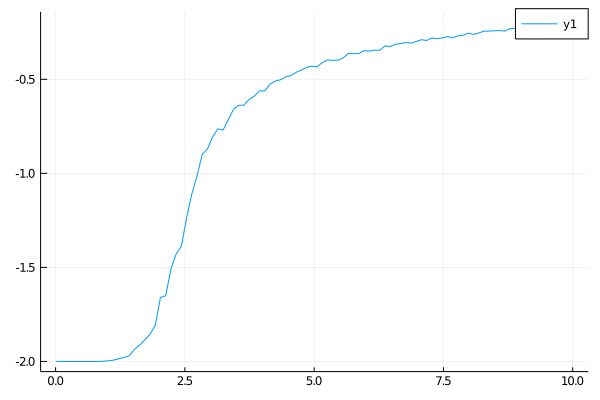

In [84]:
Temp = range(0.01, 10, length = 100)
E_site = []
for T in Temp
    push!(E_site, macrostate(spins(T,-1),5000).energy_site)
end
plot(Temp, E_site)

In [53]:
b=[ ]
push!(b,1)

1-element Array{Any,1}:
 1

1.28128 -0.9918 -0.78724 -0.89544 -0.84184 -0.78208 -0.8012 -0.67976 -1.01536 -0.8032 -1.03012 -0.83484 -0.70008 -0.8596 -0.83668 -0.78768 -1.06784 -1.06116 -0.74672 -0.68212 -0.60324 -0.67372 -0.89764 -0.65748 -0.4168 -0.56076 -0.41012 -0.55424 -0.38804 -0.54164 -0.43492 -0.43336 -0.52704 -0.47272 -0.35476 -0.38328 -0.3532 -0.31328 -0.3482 -0.31188 -0.39356 -0.2846 -0.25396 -0.2682 -0.2628 -0.251 -0.23652 -0.22784 -0.17612 -0.22212 -0.20012 -0.2724 -0.18284 -0.19968 -0.1988 -0.22624 -0.19032 -0.23672 -0.2696 -0.13576 -0.13996 -0.20496 -0.19316 -0.18412 -0.12412 -0.20036 -0.18236 -0.1668 -0.1308 -0.18736 -0.08852 -0.19384 -0.178 -0.08984 -0.13156 -0.12588 -0.11864 -0.11728 -0.18616 -0.12452 -0.15788 -0.06056 -0.16976 -0.1242 -0.12748 -0.10024 -0.18332 -0.12392 -0.13388 -0.10696 -0.06448 -0.09828 -0.0968 -0.08308 -0.00324 -0.07688 -0.06968 -0.08856 -0.13092 -0.11648 

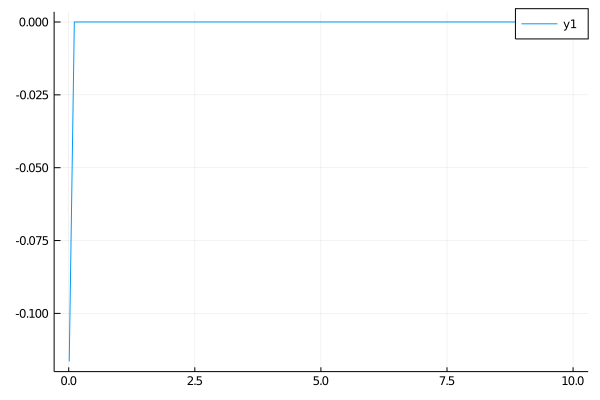

In [36]:
record = zeros(100)
for T in range(0.01, 10, length = 100)
    i = 1
    record[i] = 0
    for confs in spins(T, 1, 1000)
        record[i] = record[i] + Energy(confs)
    end
    record[i] = record[i] / 100000
    print(record[i], " ")
    i = i + 1
end
plot(range(0.01, 10, length = 100), record)

In [71]:
exp(-8 / 0.01) / (1 + exp(-8 / 0.01))

0.0